# Generalized additive models in R

In this lesson, we will learn how to implement GAMs in R, using the mgcv package. In particular, we will compare the GAM fit to other methods to show the former’s superior performance.


## Simulating the data

First, we construct three predictor variables. The goal here is to construct data with different types of predictor terms (e.g., factors, continuous variables, some that will enter linearly/parametrically, some that enter transformed).

1. $x_1$: A continuous predictor that we will suppose has a nonlinear relationship with the response.
2. $x_2$: A continuous predictor that we will suppose, has a linear relationship with the response.
3. $x_3$: A factor with three levels: $A, B, C$.

Note that I am randomly generating these predictors in a particular way, but there are lots of different options for doing this!

In [1]:
library(ggplot2)
set.seed(12)

#construct predictors 
n = 100
d = data.frame(
   x1=runif(n, -3, 3),
   x2 = rnorm(n, 3, 0.1),
   x3=as.factor(sample(c('A','B','C'),size=n,replace=TRUE)))

The model here is a Gaussian/normal GAM - so, really just an additive model (AM) - with true relationship 

$$\mu_i = E(Y_i) =  \sin\big(\frac{\pi}{2}x_1 \big) + 3 x_2 + x_3 .$$

Note that `as.integer(as.factor(VARIABLE))` converts the labels of VARIABLE to 1, 2, 3,.. so that we can construct the relationship for these factors.

Let's plot the marginal relationships...

`geom_smooth()` using method = 'loess'

`geom_smooth()` using method = 'loess'



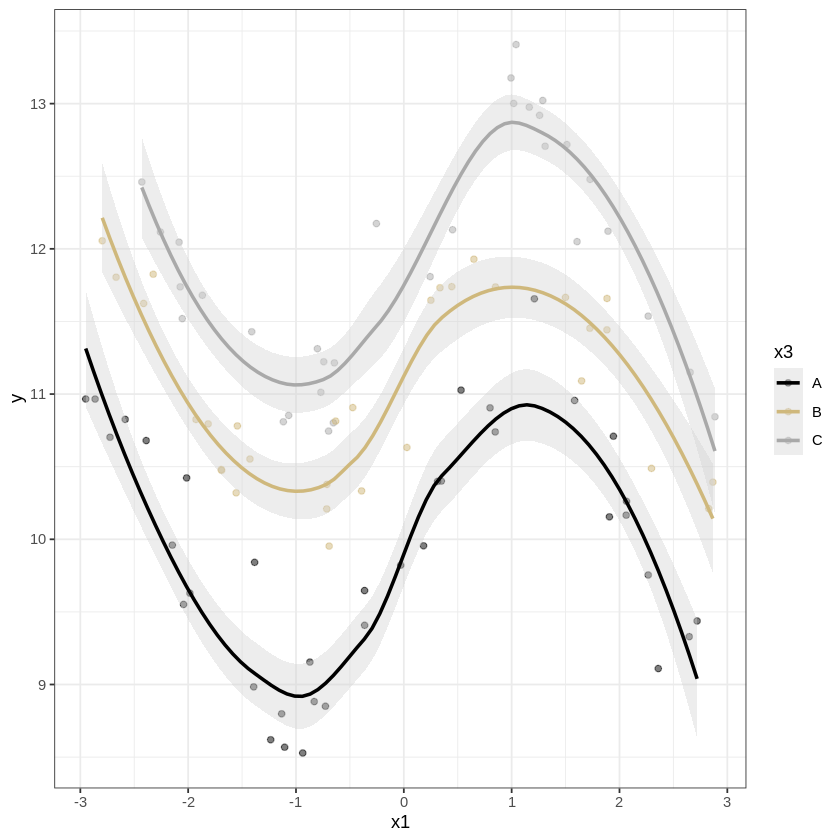

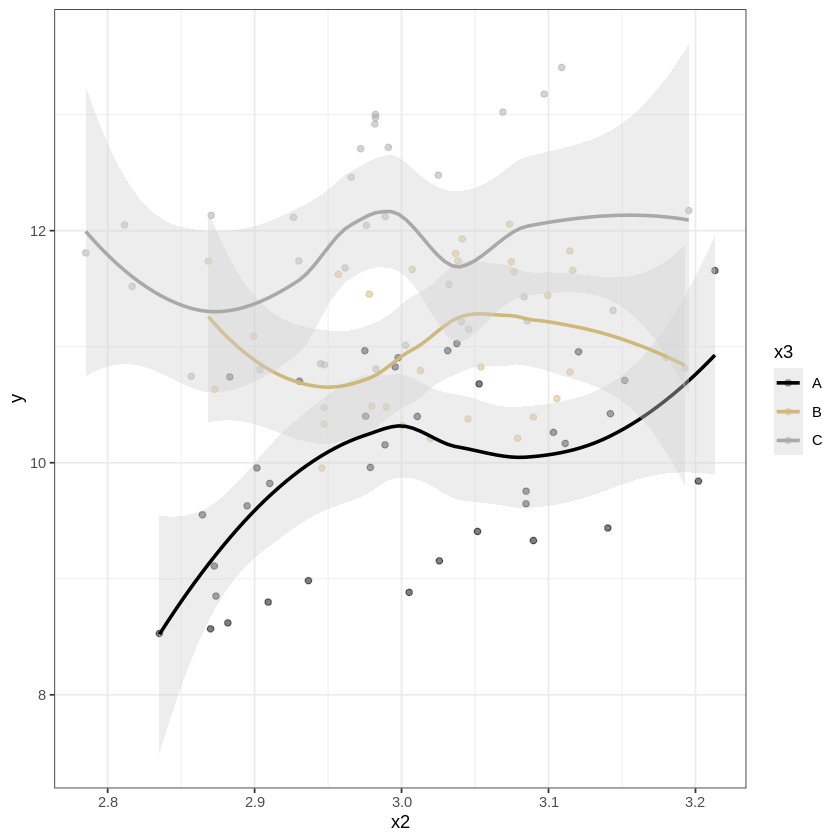

In [2]:
library(ggplot2)

#construct response
mu = with(d, sin(pi/2*x1) + 3*x2 + as.integer(x3))

d$y = rnorm(n, mu, 0.1); 

ggplot(d, aes(x1,y, col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(formula = y ~ x, fill = "lightgrey") + 
    scale_color_manual(values=c('black','#CFB87C', 'darkgrey')) +
    theme_bw() 

ggplot(d, aes(x2,y, col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(formula = y ~ x, fill = "lightgrey") + 
    scale_color_manual(values=c('black','#CFB87C', 'darkgrey')) +
    theme_bw() 

1. Without taking into account $x_2$, the loess shows a clear nonlinear relationship between $y$ and $x_1$ at every level of $x_3$.


2. Without taking into account $x_1$, the loess shows nonlinear relationship between $y$ and $x_2$ at every level of $x_3$. However, the confidence bands here are wide; in fact, it appears that, at least for levels $B$ and $C$, we could draw a straight line between the confidence bands. That suggests (as we already know), a linear fit might be reasonable!

## Standard linear regression fit

Such an analysis doesn't allow us to fit the model, adjusting for all predictors. So, to do that, we'll need some kind of multivariate model. Let's first run a linear model and show why this model doesn't fit all that well. The fit will be distorted by the nonlinear relationship between $y$ and $x_1$. Then we'll fit an AM.

In [4]:
lmod = lm(y ~ x1 + x2 + x3, d)
summary(lmod)


Call:
lm(formula = y ~ x1 + x2 + x3, data = d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.06970 -0.68029  0.01655  0.65366  1.16438 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.50735    2.41974   1.036  0.30274    
x1           0.02338    0.04544   0.515  0.60808    
x2           2.47619    0.80399   3.080  0.00271 ** 
x3B          1.02288    0.18047   5.668 1.55e-07 ***
x3C          2.01228    0.17900  11.242  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7358 on 95 degrees of freedom
Multiple R-squared:  0.5872,	Adjusted R-squared:  0.5699 
F-statistic: 33.79 on 4 and 95 DF,  p-value: < 2.2e-16


Notice that the parameter associated with $x_1$ is not significant, even though we know that there is a relationship between $x_1$ and the response.

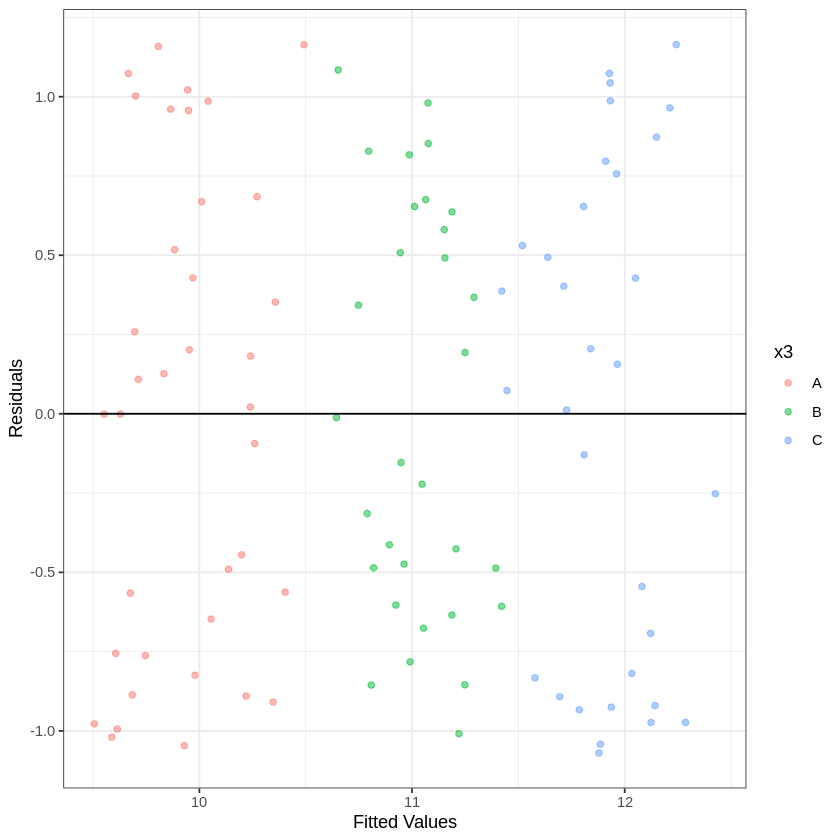

In [5]:
#residual plot
res = residuals(lmod) #compute the residuals
p = predict(lmod)
d_lm = data.frame(p, res, x3 = d$x3)
ggplot(d_lm,aes(p, res, col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    xlab("Fitted Values") +
    ylab("Residuals") +
    theme_bw() 

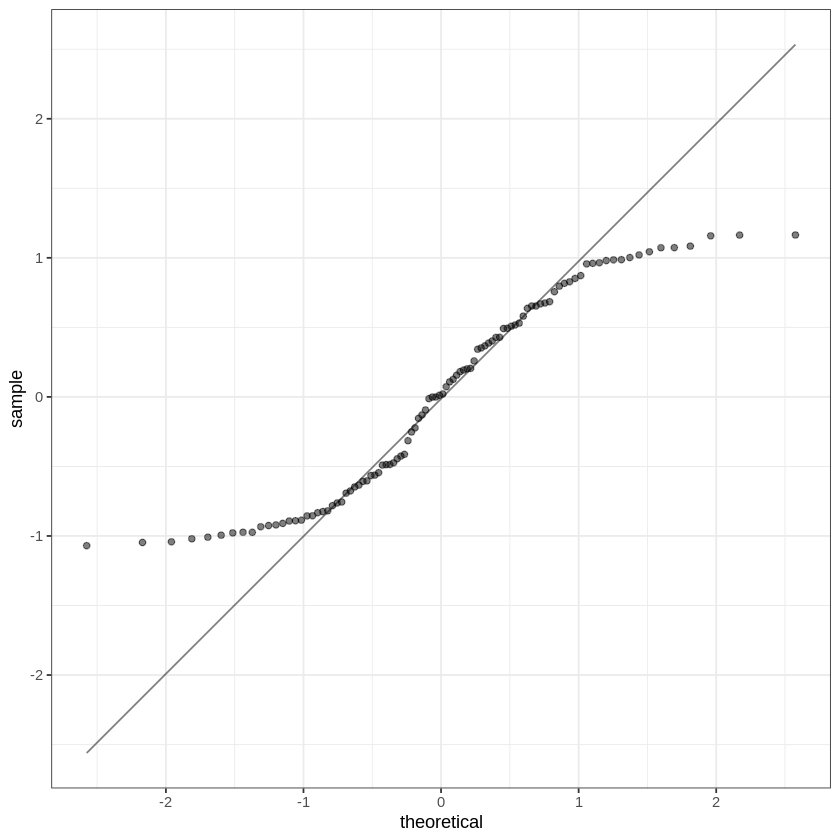

In [6]:
## qqplot
ggplot(d_lm,aes(sample = res)) + 
    stat_qq( alpha = 0.5) + stat_qq_line( alpha = 0.5) +
    theme_bw() 

We notice that:

1. The residual vs fitted plot, which is clearly ordered according to the factor levels in $x_3$, also appears to have some clumping of points, which suggests some violation of linear model assumptions. This is due to the cyclical nature of the relationship between $x_1$ and $y$.

2. The qq plot shows clear deviations from normality. Of course, these violations are not directly due to normality violations, but due to the functional form of the model being wrong.

3. Below, we see that the fitted vs predicted value plot is roughly linear around the line $y = x$. However, there seems to be quite a bit of variability. 

4. Finally, below, we compute the mean squared error (MSE) of the model, which we will use for comparison purposes.

All that to say, I think we can do better!

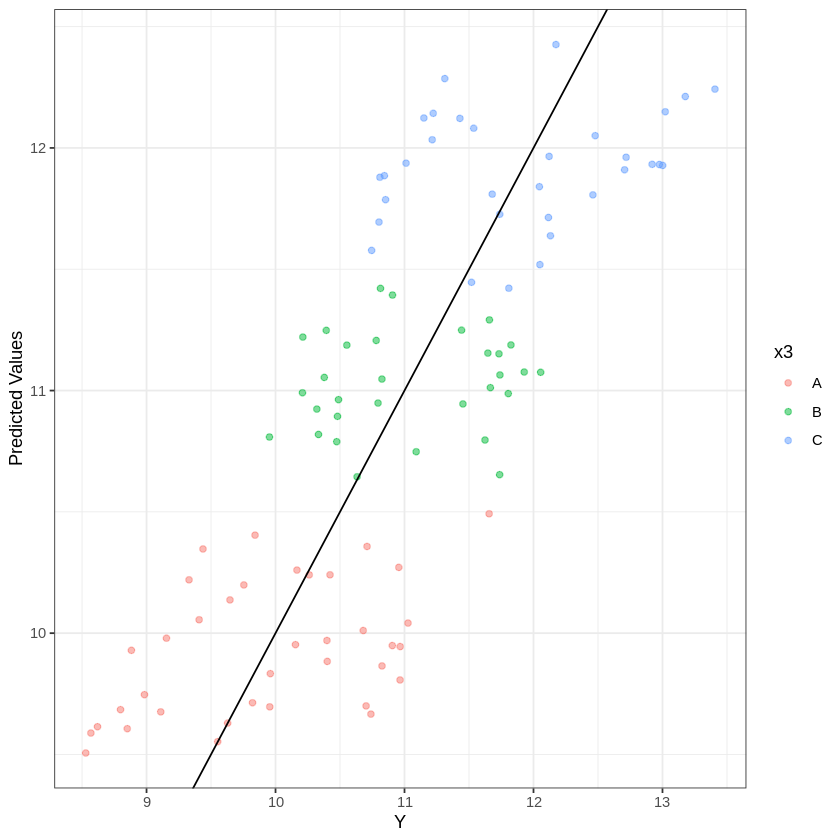

In [7]:
#fitted vs actual
ggplot(d,aes(y, predict(lmod), col = x3)) + 
    geom_point(alpha = 0.5) +
    geom_abline(slope=1) + 
    theme_bw() + 
    xlab("Y") + 
    ylab("Predicted Values") 

In [8]:
mseLM = with(d_lm, mean(res^2)); cat("the MSE for this linear regression model is ", mseLM, ".")

the MSE for this linear regression model is  0.5142885 .

## Using the true relationship in the model

If we fit the model with using the known relationship, we get a better fit. See below. Of course we can't ever do that in practice (without good theory) or through guessing. 

In [9]:
lmod2 = lm(y ~ sin(pi/2*x1) + x2 + x3, d)
summary(lmod2)
pred_error = sum((exp(predict(lmod2))-d$y)^2); #pred_error


Call:
lm(formula = y ~ sin(pi/2 * x1) + x2 + x3, data = d)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.231547 -0.057706 -0.000307  0.067945  0.190700 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     1.24980    0.29138   4.289 4.31e-05 ***
sin(pi/2 * x1)  1.00908    0.01274  79.194  < 2e-16 ***
x2              2.91257    0.09690  30.059  < 2e-16 ***
x3B             1.02686    0.02207  46.522  < 2e-16 ***
x3C             1.97291    0.02181  90.446  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09 on 95 degrees of freedom
Multiple R-squared:  0.9938,	Adjusted R-squared:  0.9936 
F-statistic:  3822 on 4 and 95 DF,  p-value: < 2.2e-16


All parameters are statistically signficant, and their magnitudes are close to their true values. 

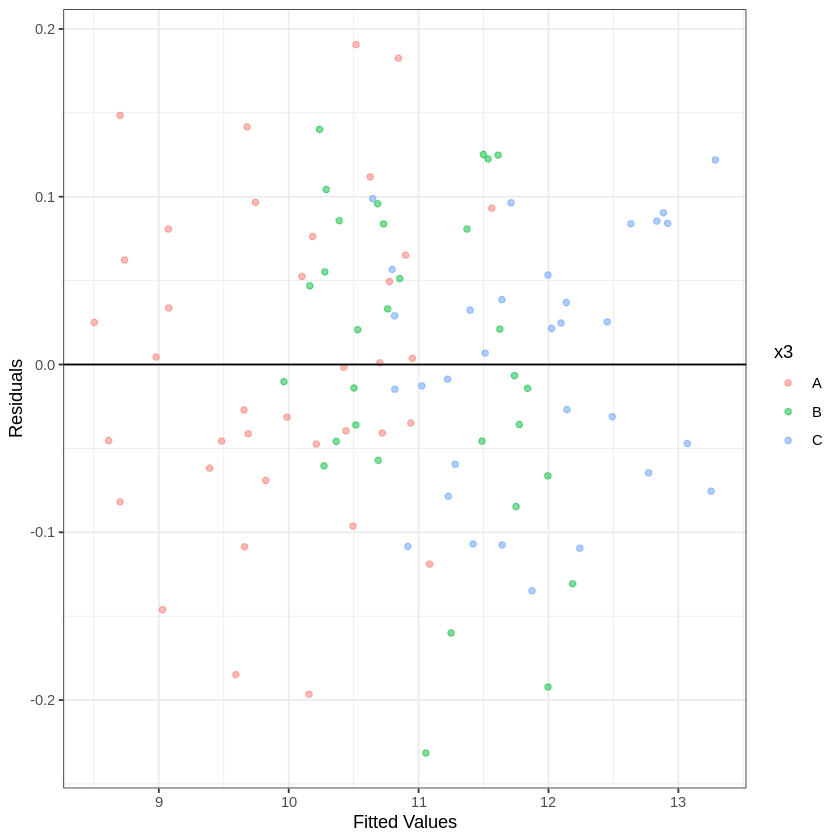

In [10]:
#residual plot
res = residuals(lmod2) #compute the residuals
p = predict(lmod2)
d_exact = data.frame(p, res, x3 = d$x3)
ggplot(d_exact,aes(p, res, col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    theme_bw() + 
    xlab("Fitted Values") +
    ylab("Residuals") 

The residual vs fitted plot looks much more like what we would expect: normal scatter around zero. 

The qq plot below suggests far less of a deviation from normality than did the previous model. Only a few values at the tails suggest a deviation from normality, which is usually not terribly important.

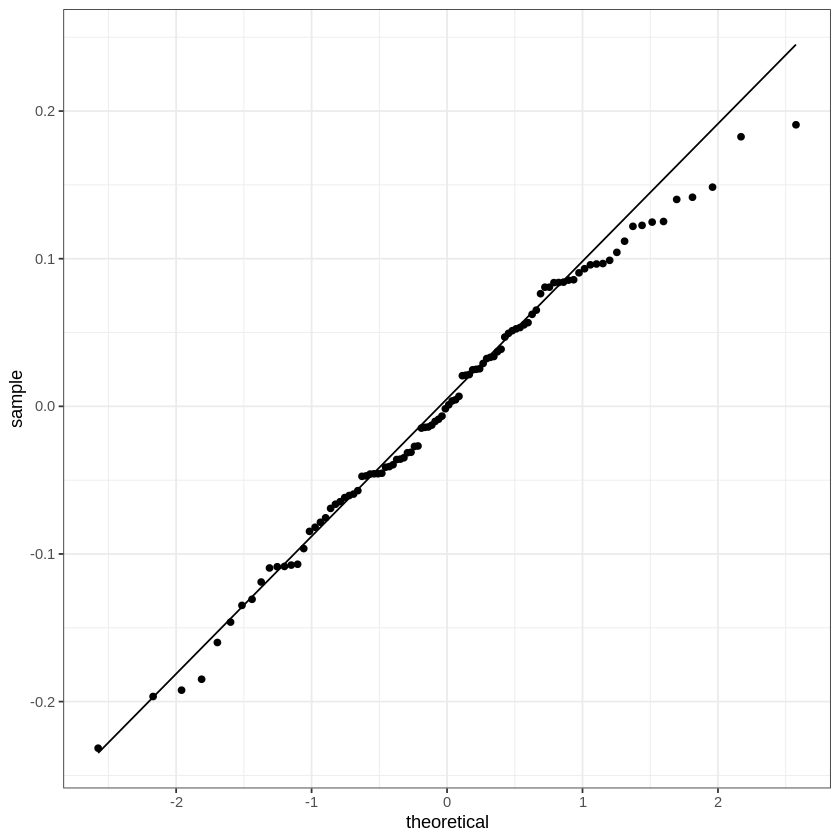

In [11]:
## qqplot
ggplot(d_exact,aes(sample = res)) + 
    stat_qq() + stat_qq_line() +
    theme_bw() 

The predicted vs actual plot shows a marked improvement over the previous model, having much less variation around the line $y = x$. Notice also (below), that the MSE for this model is much lower than the previous model, suggesting a better fit.

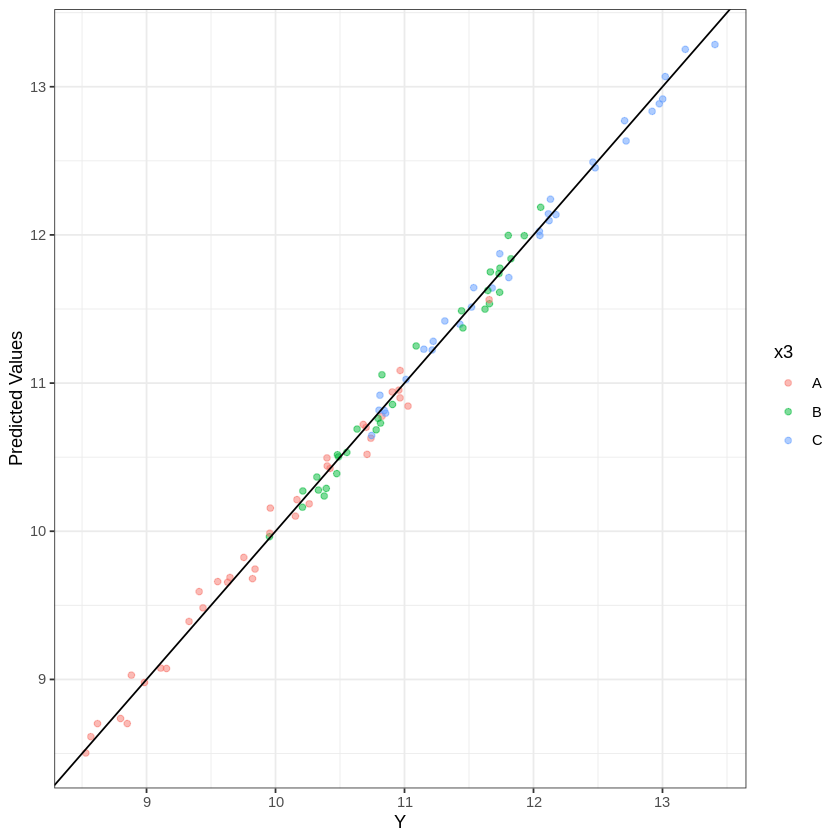

In [12]:
ggplot(d,aes(y, predict(lmod2), col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_abline(slope=1) + 
    theme_bw() +
    xlab("Y") + 
    ylab("Predicted Values") 

In [13]:
mse_exact = with(d_exact, mean(res^2)); cat("The MSE for the 'exact' model is ", mse_exact, ".")

The MSE for the 'exact' model is  0.007695232 .

## Fitting a GAM

So, when we don't know the true relationship, we try to estimate it using an additive model. Notice that we're allowing $x_2$ to enter linearly, based on explorations of the data above (using the loess fits). We'll explore what happens if we don't do that later on.

We first load the `mgcv` package in R, and fit the model using the `gam()` function. `gam()`, like `glm()`, has a `family` argument that allows the user to specify the type of regression model, e.g., poission, binomial, or Gaussian/normal. The default is Gaussian.

For now, we'll only study visual assessments of the GAM. In a future lesson, we'll consider some numerical assessments.

In [14]:
library(mgcv)
modGAM = gam(y ~ s(x1) + x2 + x3, data=d, family = gaussian)

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



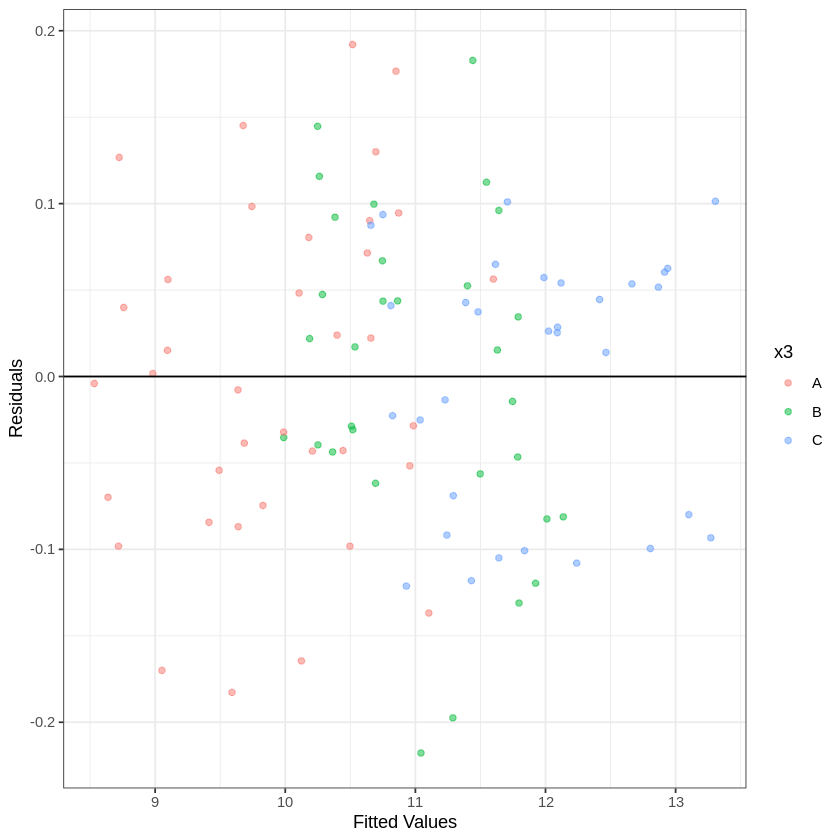

In [15]:
#residual and QQ plot
res = residuals(modGAM) 
p = predict(modGAM)
d_gam = data.frame(p, res, x3 = d$x3)
ggplot(d_gam,aes(p, res, col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_hline(yintercept = 0) + 
    xlab("Fitted Values") +
    ylab("Residuals") +
    theme_bw() 

The residual vs fitted plot looks reasonable! So does the qq plot below, with only a small and practially insignificant deviation in the lower tail.

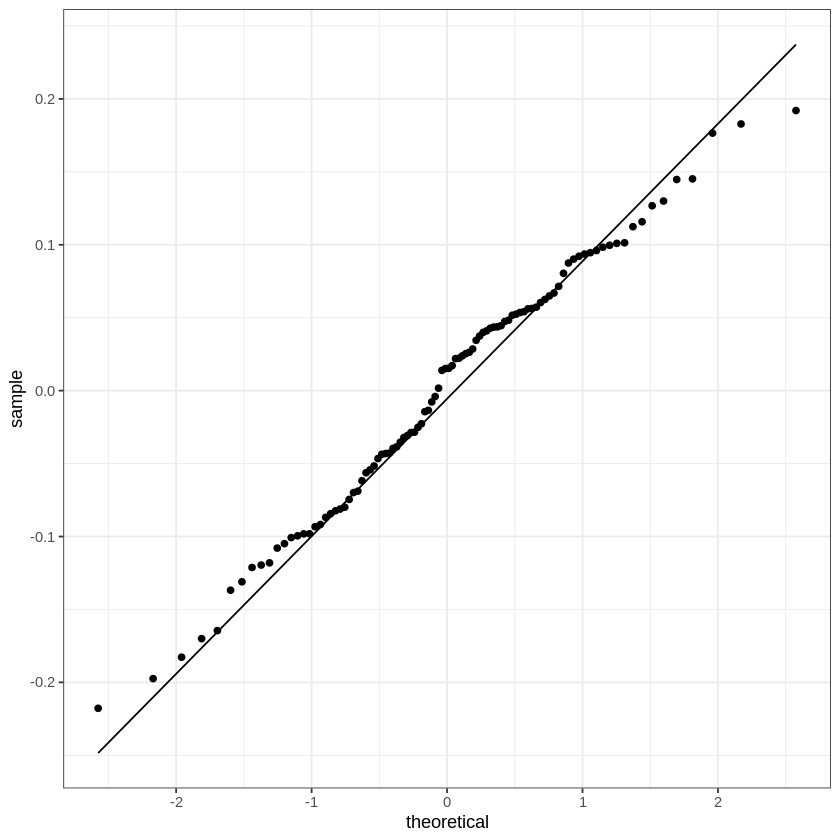

In [16]:
## qqplot
ggplot(d_gam,aes(sample = res)) + 
    stat_qq() + stat_qq_line() +
    theme_bw() 

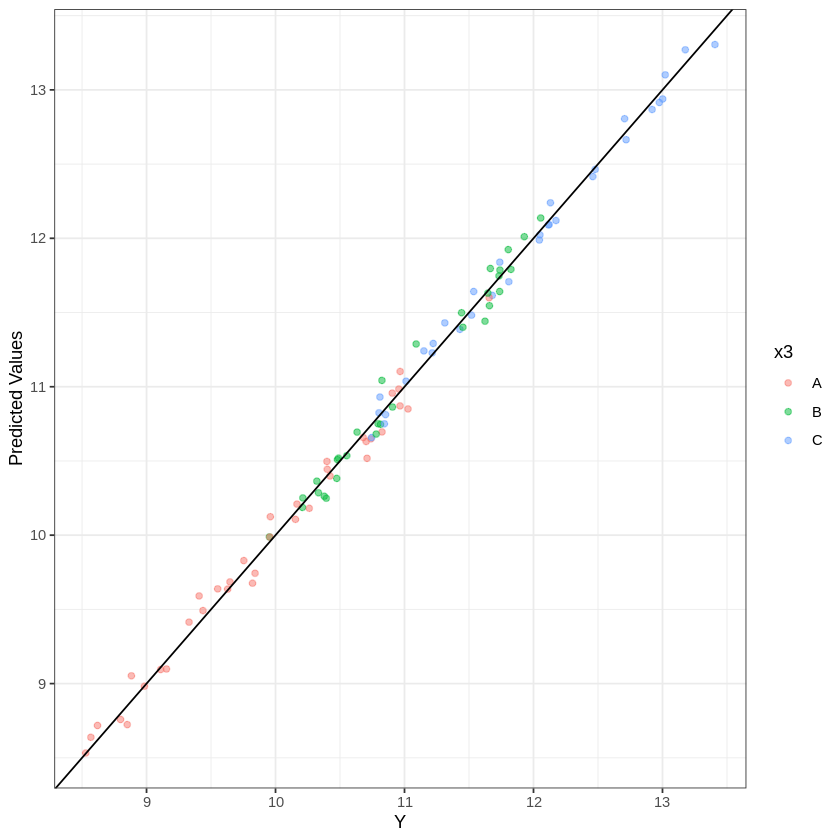

In [17]:
#fitted vs actual
ggplot(d,aes(y,predict(modGAM), col = x3)) + 
    geom_point(alpha = 0.5) + 
    geom_abline(slope=1) + 
    theme_bw() + 
    xlab("Y") + 
    ylab("Predicted Values") 

The predicted vs actual plot looks very good, similar to the "exact" model. The MSE is also very low, and much closer to the exact model than the linear model:

In [18]:
mseGAM = with(d_gam, mean(res^2)); cat("The MSE for the GAM is ", mseGAM, ".")

The MSE for the GAM is  0.007782507 .

Here's a comparison of the MSEs. 

In [19]:
mseLM = with(d_lm, mean(res^2)); cat("The MSE for the linear model is ", mseLM, ".")
mse_exact = with(d_exact, mean(res^2)); cat("The MSE for the 'exact' model is ", mse_exact, ".")
mseGAM = with(d_gam, mean(res^2)); cat("The MSE for the GAM is ", mseGAM, ".")

The MSE for the linear model is  0.5142885 .The MSE for the 'exact' model is  0.007695232 .The MSE for the GAM is  0.007782507 .